In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import sqlite3
from pathlib import Path
from lmfit.models import LinearModel
from lmfit import Parameters, minimize, report_fit
import statsmodels.formula.api as smf
from scipy import constants

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

# set font size
mpl.rcParams.update({'font.size': 7})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [3]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [4]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id,
            mn.site,
            UPPER(mn.base) AS base
        FROM probe_tc_fit_runs r
        JOIN meta_nucleotides mn ON mn.id = r.nt_id
        WHERE r.fit_kind = 'round3_constrained'
          AND r.valtype  = 'modrate'
    )
    SELECT
        r.rg_id,
        r.site,
        r.base,
        MIN(pr.temperature) AS temperature,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                 THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                 THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')
                 THEN p.param_numeric END) AS log_fmod0,
        MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')
                 THEN p.param_numeric END) AS log_fmod0_err,
        MAX(CASE WHEN p.param_name = 'diag:r2'
                 THEN p.param_numeric END) AS diag_r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id, r.site, r.base
    """
    )

# Preprocess k_vals to get k_add-like values
fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
conc_DMS = 0.015852692  # in M, 1.5% v/v
# log_kobs in nerd is kappa for now, need to correct later
# new log_kobs below is K/K+1 kadd [P]_0
fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg']
fit_params_df

,rg_id,site,base,temperature,disp_name,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,log_fmod0,log_fmod0_err,diag_r2,inv_temp
0,20,1,A,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002832
1,20,2,G,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002832
2,20,3,G,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002832
3,20,4,U,80.0,4U_wt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002832
4,20,5,U,80.0,4U_wt,-35.937778,-4.606971,NaN,NaN,-7.333277,NaN,-2.300249e-11,0.002832
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,130,263,C,23.0,p4p6_wt_nobc,-13.859980,-8.181574,0.234228,0.0,-6.492785,0.434736,7.853063e-01,0.003377
4719,130,264,C,23.0,p4p6_wt_nobc,-15.035101,-8.181574,0.634883,0.0,-6.857317,0.525053,3.318751e-01,0.003377
4720,130,265,A,23.0,p4p6_wt_nobc,-13.942986,-8.181574,0.165945,0.0,-7.833714,1.083826,8.793265e-01,0.003377
4721,130,266,A,23.0,p4p6_wt_nobc,-13.858719,-8.181574,0.197353,0.0,-7.881440,1.470308,8.374605e-01,0.003377


In [5]:
fit_params_25C = fit_params_df[fit_params_df['temperature'] == 25]

# filter to A's and C's
fit_params_25C = fit_params_25C[fit_params_25C['base'].isin(['A', 'C'])]

# drop rows with diag_r2 < 0.5
fit_params_25C = fit_params_25C[fit_params_25C['diag_r2'] >= 0.5]

In [6]:
def calculate_reactivity_at_t(log_kobs, log_kdeg, log_fmod0, t=600):
    """Calculate reactivity at time t (in seconds) given log_kobs, log_kdeg, and log_fmod0."""
    kobs = np.exp(log_kobs)
    kdeg = np.exp(log_kdeg)
    fmod0 = np.exp(log_fmod0)

    kappa = kobs / kdeg

    fmod_t = 1 - np.exp(-kappa * (1 - np.exp(-kdeg * t))) + fmod0

    return fmod_t

Text(0.5, 0, 'Time (s)')

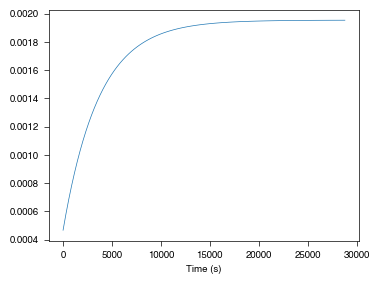

In [14]:
# test for one row

t = np.linspace(0, 28800, 100)  # time from 0 to 3600 seconds
log_kobs = fit_params_25C.iloc[0]['log_kobs']
log_kdeg = fit_params_25C.iloc[0]['log_kdeg']
log_fmod0 = fit_params_25C.iloc[0]['log_fmod0']

fmod_t = calculate_reactivity_at_t(log_kobs, log_kdeg, log_fmod0, t)

# plot
plt.figure(figsize=(4, 3))
plt.plot(t, fmod_t, label=f"Site {fit_params_25C.iloc[0]['site']}")
plt.xlabel("Time (s)")

In [10]:
# calculate reactivity at 15 mins

# filter to disp_name containing '4U_'
fit_params_25C_wt = fit_params_25C[fit_params_25C['disp_name'].str.contains('4U_wt')]
fit_params_25C_wt['fmod_15min'] = fit_params_25C_wt.apply(
    lambda row: calculate_reactivity_at_t(
        row['log_kobs'], row['log_kdeg'], row['log_fmod0'], t=900
    ),
    axis=1
)
fit_params_25C_wt['ln_reactivity_15min'] = np.log(fit_params_25C_wt['fmod_15min'])


# calculate fmod at infinity (some large t)
fit_params_25C_wt['fmod_infinity'] = fit_params_25C_wt.apply(
    lambda row: calculate_reactivity_at_t(
        row['log_kobs'], row['log_kdeg'], row['log_fmod0'], t=1e6
    ),
    axis=1
)

fit_params_25C_wt['ln_reactivity_infinity'] = np.log(fit_params_25C_wt['fmod_infinity'])

# group by site and calculate mean fmod_15min, ln_reactivity_15min, fmod_infinity, ln_reactivity_infinity
fit_params_25C_wt_grouped = fit_params_25C_wt.groupby(['site', 'base']).agg({
    'fmod_15min': 'mean',
    'ln_reactivity_15min': 'mean',
    'fmod_infinity': 'mean',
    'ln_reactivity_infinity': 'mean'
}).reset_index()

fit_params_25C_wt_grouped.to_csv('ln_reactivity_25C_4U_wt.csv', index=False)

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_89811/1774042669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_params_25C_wt['fmod_15min'] = fit_params_25C_wt.apply(
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_89811/1774042669.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_params_25C_wt['ln_reactivity_15min'] = np.log(fit_params_25C_wt['fmod_15min'])
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_89811/1774042669.py:15: SettingWithCopyWarning: 
A val

In [13]:
# calculate reactivity at 15 mins

# filter to disp_name containing '4U_'
fit_params_25C_wt = fit_params_25C[fit_params_25C['disp_name'].str.contains('4U_a8c')]
fit_params_25C_wt['fmod_15min'] = fit_params_25C_wt.apply(
    lambda row: calculate_reactivity_at_t(
        row['log_kobs'], row['log_kdeg'], row['log_fmod0'], t=900
    ),
    axis=1
)
fit_params_25C_wt['ln_reactivity_15min'] = np.log(fit_params_25C_wt['fmod_15min'])


# calculate fmod at infinity (some large t)
fit_params_25C_wt['fmod_infinity'] = fit_params_25C_wt.apply(
    lambda row: calculate_reactivity_at_t(
        row['log_kobs'], row['log_kdeg'], row['log_fmod0'], t=1e6
    ),
    axis=1
)

fit_params_25C_wt['ln_reactivity_infinity'] = np.log(fit_params_25C_wt['fmod_infinity'])

# group by site and calculate mean fmod_15min, ln_reactivity_15min, fmod_infinity, ln_reactivity_infinity
fit_params_25C_wt_grouped = fit_params_25C_wt.groupby(['site', 'base']).agg({
    'fmod_15min': 'mean',
    'ln_reactivity_15min': 'mean',
    'fmod_infinity': 'mean',
    'ln_reactivity_infinity': 'mean'
}).reset_index()

fit_params_25C_wt_grouped.to_csv('ln_reactivity_25C_4U_a8c.csv', index=False)

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_89811/2059597483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_params_25C_wt['fmod_15min'] = fit_params_25C_wt.apply(
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_89811/2059597483.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_params_25C_wt['ln_reactivity_15min'] = np.log(fit_params_25C_wt['fmod_15min'])
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_89811/2059597483.py:15: SettingWithCopyWarning: 
A val